## Makeplot for HTML Monitor for Environmental Overview

plot most of observations for ROMY combined as time series

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np
import obspy as obs

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

In [2]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data
from functions.read_sds import __read_sds
from functions.read_yaml import __readYaml
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals
from functions.load_furt_stream import __load_furt_stream
from functions.backscatter_correction import __backscatter_correction

from functions.load_mlti import __load_mlti
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.interpolate_nan import __interpolate_nan
from functions.smoothing import __smooth
from functions.conversion_to_tilt import __conversion_to_tilt
from functions.load_water_level import __load_water_level
from functions.load_beam_wander_data import __load_beam_wander_data
from functions.find_max_min import __find_max_min
from functions.find_labels import __find_lables

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Configurations

In [5]:
config = {}

config['ring'] = "Z"

# specify limits for sagnac frequency
# config['flim1'], config['flim2'] = 447.726, 447.745

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

# specify length of time interval to show
config['time_interval'] = 14 # days

config['last_reset'] = UTCDateTime("2024-10-23 12:00")

# define time interval
config['tend'] = UTCDateTime().now()
if abs(config['tend'] - config['last_reset']) > config['time_interval']*86400:
    config['tbeg'] = config['tend'] - config['time_interval'] * 86400
else:
    config['tbeg'] = config['last_reset']

# define path to data
config['path_to_sds'] = archive_path+"romy_archive/"

# path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

# path to figure output
config['path_to_figs'] = data_path+f"HTML_Monitor/figures/"

# specify wromy stations to use
config['wromy_stations'] = [1, 4, 5, 6, 7, 8, 9]

# specify promy stations to use
config['promy_stations'] = [1, 4, 5, 7, 9]

# specify colors for stations
config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }


In [6]:
def __time_spans_to_nan(bs, time_spans):

    for t1, t2 in time_spans:
        bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
        bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)

## Configurations

In [7]:
try:
    # load sagnac frequency data
    bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

    # add column with seconds
    bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

except:
    pass

### Compute Backscatter (again)

In [8]:
try:
    # unwrap phases as one time series
    bs['fj_ph'] = np.unwrap(bs.fj_ph)
    bs['f1_ph'] = np.unwrap(bs.f1_ph)
    bs['f2_ph'] = np.unwrap(bs.f2_ph)

    # fractional beat modulations
    m01 = bs.f1_ac / bs.f1_dc
    m02 = bs.f2_ac / bs.f2_dc

    # phase difference
    ph1 = bs.f1_ph
    ph2 = bs.f2_ph
    phase0 = ph2 - ph1

    # compute backscatter corrected signal
    bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, bs.fj_fs, np.median(bs.fj_fs), cm_filter_factor=1.033)
except:
    pass

### Cut corrupt data periods

In [9]:
try:
    bs['fj_fs'] = np.where((bs.fj_fs > config['flim2']), np.nan, bs.fj_fs)
    bs['fj_fs'] = np.where((bs.fj_fs < config['flim1']), np.nan, bs.fj_fs)

    bs['fj_bs'] = np.where((bs.fj_bs > config['flim2']), np.nan, bs.fj_bs)
    bs['fj_bs'] = np.where((bs.fj_bs < config['flim1']), np.nan, bs.fj_bs)
except:
    pass

In [10]:
# time_spans = [("2024-06-20T12:00", "2024-06-21T12:00"),
#               ("2024-06-24T12:00", "2024-06-26T06:00")
#              ]

# __time_spans_to_nan(bs, time_spans)

In [11]:
try:
    mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

    mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

    bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)
    bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=300)
except:
    print(f" -> Error: MLTI log")
    pass

### Apply special filter sections

In [12]:
try:
    bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
    bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

    n_minutes = 30

    bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
    bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

except:
    pass

### Load LXX maintenance

In [13]:
try:
    lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

    lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)
except:
    print(f" -> Error: maintendance log")
    pass

### Checkup Plot

In [14]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_bs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_bs_nan, color="tab:blue", label="cleaned")
    ax.plot(bs.time_sec*time_scaling, bs.fj_bs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")

    ax.set_ylim(config['flim1'], config['flim2'])
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([config['flim1'], config['flim2']], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

# fig = __makeplot();

### Load WROMY Data

In [15]:
ws = Stream()

try:
    ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
    ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.05.LKI", config['tbeg'], config['tend'])
    ws += __read_sds(archive_path+"temp_archive/", "BW.WROMY.09.LKI", config['tbeg'], config['tend'])

    ws = ws.merge();

except:
    print(f" -> Error: WROMY data")
    pass

### Load PROMY Data

In [16]:
ps = Stream()

try:
    ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
    ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.03.LKI", config['tbeg'], config['tend'])
    ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.05.LKI", config['tbeg'], config['tend'])
    ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", config['tbeg'], config['tend'])
    ps += __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

    ps3 = ps.merge();

except:
    print(f" -> Error: PROMY data")
    pass

### Load Rain Data

In [17]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [18]:
try:
    furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')
except:
    print(f" -> Error: FURT data")
    pass

Specified end: 2024-10-25T08:32:34.978707Z 
Trace end:     2024-10-25T08:20:06.000000Z


In [19]:
try:
    rain = furt.select(channel="LAR")

    rain = rain.trim(config['tbeg'], config['tend'])

    for tr in rain:
        tr.data = np.nan_to_num(tr.data, 0)

    # smoothed precipitation
    rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)

    # cumulative rain
    rain_cumsum = np.nancumsum(rain[0].data)
except:
    print(f" -> Error: rain data processing")
    pass

### Load Tilt Data

In [20]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

tromy0 = obs.Stream()

try:
    tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAN", config['tbeg']-600, config['tend']+600)
    tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAE", config['tbeg']-600, config['tend']+600)
    tromy0 += __read_sds(path_to_tilt, "BW.ROMYT..MAT", config['tbeg']-600, config['tend']+600)
except:
    print(f" -> Error: TROMY data")
    pass

In [21]:
try:
    # tiltmeter configurations
    confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

    tromy0 = __conversion_to_tilt(tromy0, confTilt['TROMY'])

    tromy0 = tromy0.trim(config['tbeg'], config['tend']);

    tromy = tromy0.copy();

    tromy = tromy.merge(fill_value="interpolate");

    del tromy0

    # create smoothed data
    tromyN_smooth = __smooth(__reduce(tromy.select(channel="*N")[0].data, 100), int(20*tromy.select(channel="*N")[0].stats.sampling_rate))
    tromyE_smooth = __smooth(__reduce(tromy.select(channel="*E")[0].data, 100), int(20*tromy.select(channel="*E")[0].stats.sampling_rate))

except:
    print(f" -> Error: TROMY data processing")
    pass

  -> converted data of ROMYT


### Load Water Level Data

In [22]:
try:
    pegel =  __load_water_level(config['tbeg'], config['tend'], path_to_data=lamont_path+"Pegel/")

    ## remove error measurements with nan
    pegel['pegel'] = np.where(pegel.pegel <= 0, np.nan, pegel.pegel)

except:
    print(f" -> Error: Pegel data")
    pass

 -> Error: Pegel data


### Load Beam Wander Data

In [23]:
try:
    cam = "01"

    bw1 = __load_beam_wander_data(config['tbeg'].date, config['tend'].date, data_path+f"ids/data{cam}/")

except:
    print(f" -> Error: beam walk 03")
    pass

2024-10-23
2024-10-24
2024-10-25
error for 20241025.pkl


In [24]:
try:
    cam = "03"

    bw3 = __load_beam_wander_data(config['tbeg'].date, config['tend'].date, data_path+f"ids/data{cam}/")

except:
    print(f" -> Error: beam walk 03")
    pass

2024-10-23
2024-10-24
2024-10-25
error for 20241025.pkl


In [25]:
try:
    cam = "05"

    bw5 = __load_beam_wander_data(config['tbeg'].date, config['tend'].date, data_path+f"ids/data{cam}/")

except:
    print(f" -> Error: beam walk 03")
    pass

2024-10-23
2024-10-24
2024-10-25
error for 20241025.pkl


In [26]:
def processing(_bw):

    _bw = _bw[(_bw.time > config['tbeg']) & (_bw.time < config['tend'])]

    _bw['time_utc'] = np.array([UTCDateTime(_t) for _t in _bw.time])

    # conversion from pixel to mm
    config['conversion'] = {"XX":1.67e-3,
                            "01":5.3e-3,
                            "03":5.3e-3,
                            "05":5.3e-3,
                            "07":5.3e-3,
                           }

    _bw['x_mm'] = _bw.x*config['conversion'][cam]
    _bw['y_mm'] = _bw.y*config['conversion'][cam]

    _bw['x_mm'] = __reduce(_bw.x_mm, 100)
    _bw['y_mm'] = __reduce(_bw.y_mm, 100)

    _bw = _bw[_bw.amp > 20]
    _bw = _bw[_bw.amp < 255]

    return _bw

In [27]:
try:
    bw1 = processing(bw1)
except:
    print(f" -> Error: beam wander data processing")
    pass

In [28]:
try:
    bw3 = processing(bw3)
except:
    print(f" -> Error: beam wander data processing")
    pass

In [29]:
try:
    bw5 = processing(bw5)
except:
    print(f" -> Error: beam wander data processing")
    pass

In [30]:
bws = [bw1, bw3, bw5]

In [31]:
gc.collect()

0

### Load Infrasound FFBI

In [32]:
ffbi = obs.Stream()

try:
    ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDF", config['tbeg'], config['tend'])
    ffbi += __read_sds(archive_path+"temp_archive/", "BW.FFBI.30.LDO", config['tbeg'], config['tend'])

    # create smoothed data
    ffbi_bdf_smooth1 = __smooth(ffbi.select(channel="*F")[0].data, int(60*ffbi.select(channel="*F")[0].stats.sampling_rate))
    ffbi_bdf_smooth2 = __smooth(ffbi.select(channel="*F")[0].data, int(3600*ffbi.select(channel="*F")[0].stats.sampling_rate))

except:
    print(f" -> Error: FFBI data")
    pass

## Plotting

In [33]:
def __makeplot():

    Nrow, Ncol = 6, 1

    font = 10

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(9, 11), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    time_scaling = 1

    # ref_date = UTCDateTime(bs.time1.iloc[0])
    ref_date = UTCDateTime(config['tbeg'])

    bs_time_sec = [_t - config['tbeg'] for _t in bs.time1]

    # _____________________________________________________________________________________

    try:
        ax[0].plot(bs_time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
        ax[0].plot(bs_time_sec*time_scaling, bs.fj_fs_nan, color="black", label="cleaned")
        ax[0].plot(bs_time_sec*time_scaling, bs.fj_bs_nan, color="red", label=f"BS corrected")
        ax[0].plot(bs_time_sec*time_scaling, bs.fj_bs_smooth, color="white", lw=1)
        # ax[0].plot(bs_time_sec*time_scaling, bs.fj_bs_dejump, color="gold", lw=1, label=f"BS dejump")

        f_min, f_max = __find_max_min([bs.fj_fs_nan], 99)
        if f_min < 553.40:
            f_min = 553.50
        if f_max > 553.6:
            f_max = 553.6
        ax[0].set_ylim(f_min-0.001, f_max+0.001)

        ax[0].ticklabel_format(useOffset=False)
        ax[0].set_ylabel(f"R{config['ring']} $\delta f$ (Hz)", fontsize=font)
    except:
        pass

    # _____________________________________________________________________________________

    try:

        for tr in ws.select(channel="*T"):
            num = int(tr.stats.location[-1])
            if num != 1:
                ax[1].plot(tr.times(reftime=ref_date),
                           __smooth(tr.data, 600), color=config['colors'][num], label=f"WS{num}", alpha=0.7)

        for tr in ps.select(channel="*KI"):
            num = int(tr.stats.location[-1])
            if num != 1:
                ax[1].plot(tr.times(reftime=ref_date),
                           __smooth(tr.data, 600), color=config['colors'][num], label=f"PS{num}", alpha=0.7)

        T_min, T_max = __find_max_min([_ps.data for _ps in ps.select(channel="*KI") if "1" not in _ps.stats.location], 98)
        ax[1].set_ylim(T_min, T_max)

        ax[1].set_ylabel("Temp. (°C)", fontsize=font)

        ax11 = ax[1].twinx()
        ax11.plot(ps.select(location="01", channel="*KI")[0].times(reftime=UTCDateTime(ref_date)),
                  __smooth(ps.select(location="01", channel="*KI")[0].data, 600), color=config['colors'][1], label="PS1")

        ax11.set_ylabel("Temp. (°C)", fontsize=font, color=config['colors'][1])
        [t.set_color(config['colors'][1]) for t in ax11.yaxis.get_ticklabels()]
        ax[1].set_yticks(np.linspace(ax[1].get_yticks()[0], ax[1].get_yticks()[-1], len(ax[1].get_yticks())))
        ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    except:
        pass

    # _____________________________________________________________________________________

    try:
        ax[2].plot(pegel.times_utc - ref_date, pegel.pegel, color="purple", alpha=0.9, zorder=3)
    except:
        pass
    ax[2].set_ylabel(f"Water Level (m)", fontsize=font, color="purple")
    # ax[2].set_zorder(3)
    [t.set_color("purple") for t in ax[2].yaxis.get_ticklabels()]

    ax22 = ax[2].twinx()
    ax22.fill_between(rain[0].times(reftime=ref_date),
                      __interpolate_nan(rain[0].data), color="tab:blue", alpha=0.6, label=f"rain", zorder=0)

    ax22.set_ylim(bottom=0)
    ax22.set_ylabel(f"Rain (mm)", fontsize=font, color="tab:blue")
    [t.set_color('tab:blue') for t in ax22.yaxis.get_ticklabels()]

    ax[2].set_yticks(np.linspace(ax[2].get_yticks()[0], ax[2].get_yticks()[-1], len(ax[2].get_yticks())))
    ax22.set_yticks(np.linspace(ax22.get_yticks()[0], ax22.get_yticks()[-1], len(ax[2].get_yticks())))
    # ax22.set_zorder(2)

    ax24 = ax[2].twinx()
    ax24.plot(rain[0].times(reftime=ref_date), rain_cumsum/max(rain_cumsum)*100, alpha=0.9, zorder=1, ls="--", color="darkblue")

    # ax24.axis('off')
    # ax24.set_zorder(1)
    ax24.spines.right.set_position(("axes", 1.1))
    ax24.set_ylabel(f"Cum. Rain (%)", fontsize=font, color="darkblue")
    [t.set_color('darkblue') for t in ax24.yaxis.get_ticklabels()]

    # _____________________________________________________________________________________

    try:
        ax[3].plot(tromy.select(channel="*N")[0].times(reftime=ref_date)[:-20],
                   tromyN_smooth[:-20]*1e6,
                   label=f"T{tromy[0].stats.station} N-S (20 sec. avg.)", color="tab:orange")
        ax[3].plot(tromy.select(channel="*E")[0].times(reftime=ref_date)[:-20],
                   tromyE_smooth[:-20]*1e6,
                   label=f"T{tromy[0].stats.station} E-W (20 sec. avg.)", color="tab:brown")

        # ax[3].plot(bromy.select(channel="*N")[0].times(reftime=UTCDateTime(ref_date))[:-20],
        #            bromyN_smooth[:-20]*1e6,
        #            label=f"T{bromy[0].stats.station} N-S (20 sec. avg.)", color="tab:red")
        # ax[3].plot(bromy.select(channel="*E")[0].times(reftime=UTCDateTime(ref_date))[:-20],
        #            bromyE_smooth[:-20]*1e6,
        #            label=f"T{bromy[0].stats.station} E-W (20 sec. avg.)", color="tab:blue")

        ax[3].set_ylabel("Tilt ($\mu$rad)", fontsize=font)

        y_max = max(np.nanpercentile(tromyN_smooth, 99)*1e6, np.nanpercentile(tromyE_smooth, 99)*1e6)
        y_min = min(np.nanpercentile(tromyN_smooth, 1)*1e6, np.nanpercentile(tromyE_smooth, 1)*1e6)
        ax[3].set_ylim(y_min*1.2, y_max*1.2)
    except:
        pass


    # _____________________________________________________________________________________

    try:
        ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=ref_date),
                   ffbi_bdf_smooth1,
                   label=f"{ffbi.select(channel='*F')[0].stats.station}.{ffbi.select(channel='*F')[0].stats.channel} (1 min. avg.)",
                   color="tab:red"
                  )
        ax[4].plot(ffbi.select(channel="*F")[0].times(reftime=ref_date),
                   ffbi_bdf_smooth2,
                   color="white", ls="-", lw=1,
                  )

        ax[4].set_ylabel("Differential \n Pressure (Pa)", fontsize=font)

        ax41 = ax[4].twinx()
        ax41.plot(ffbi.select(channel="*O")[0].times(reftime=ref_date),
                  ffbi.select(channel="*O")[0].data,
                  color="darkred"
                  )
        ax41.set_ylabel("Pressure (hPa)", fontsize=font, color="darkred")
        [t.set_color('darkred') for t in ax41.yaxis.get_ticklabels()]

        # ------------------------------------------------
        # add wind direction
        # ax42 = ax[4].twinx()
        # ax42.scatter(furt.select(channel="*D")[0].times(reftime=config['tbeg']),
        #              __smooth(furt.select(channel="*D")[0].data, 3600), color="peru", s=0.5, alpha=0.5,
        #             )
        # ax42.spines.right.set_position(("axes", 1.1))
        # ax42.set_ylabel("Wind Direction (°)", fontsize=font, color="peru")
        # [t.set_color('peru') for t in ax42.yaxis.get_ticklabels()]
        # ax42.set_ylim(0, 360)
        # ax42.set_zorder(1)
    except:
        pass

    # _____________________________________________________________________________________

    try:
        try:
            ax[5].plot(bw1.time_utc - ref_date,
                          bw1.x_mm*1e3,
                          label=f"IDS01-X",
                          color=config['colors'][1],
                          zorder=2,
                          ls="--",
                      )

            ax[5].plot(bw1.time_utc - ref_date,
                          bw1.y_mm*1e3,
                          label=f"IDS01-Y",
                          color=config['colors'][1],
                          zorder=2,
                      )
        except:
            pass

        try:
            ax[5].plot(bw3.time_utc - ref_date,
                          bw3.x_mm*1e3,
                          label=f"IDS03-X",
                          color=config['colors'][3],
                          zorder=2,
                          ls="--",
                      )

            ax[5].plot(bw3.time_utc - ref_date,
                          bw3.y_mm*1e3,
                          label=f"IDS03-Y",
                          color=config['colors'][3],
                          zorder=2,
                      )
        except:
            pass

        try:
            ax[5].plot(bw5.time_utc - ref_date,
                          bw5.x_mm*1e3,
                          label=f"IDS05-X",
                          color=config['colors'][5],
                          zorder=2,
                          ls="--",
                      )

            ax[5].plot(bw5.time_utc - ref_date,
                          bw5.y_mm*1e3,
                          label=f"IDS05-Y",
                          color=config['colors'][5],
                          zorder=2,
                      )
        except:
            pass

        ax[5].set_ylabel("rel. Beam \n Position ($\mu$m)", fontsize=font)

        bws = [bw1.x_mm*1e3, bw1.y_mm*1e3, bw3.x_mm*1e3, bw3.y_mm*1e3, bw5.x_mm*1e3, bw5.y_mm*1e3]
        bw_min, bw_max = __find_max_min(bws, 99)
        ax[5].set_ylim(bw_min, bw_max)
    except:
        pass

    # _____________________________________________________________________________________


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0, alpha=0.5)
        # ax[_n].set_xlim(left=0, right=np.array(bs.time_sec)[-1]*time_scaling)
        ax[_n].set_xlim(0, (config['tend'] - config['tbeg'])*time_scaling)
        _, _ , _ymin, _ymax = ax[_n].axis()

        # add maintenance
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([_ymin, _ymax], lx1_sec*time_scaling, lx2_sec*time_scaling, color="yellow", alpha=0.5)

    ax[0].legend(loc='best', ncol=4, fontsize=font-1)
    ax[1].legend(loc='best', ncol=4, fontsize=font-1)
    ax11.legend(loc='best', ncol=1, fontsize=font-1)
    ax[3].legend(loc='best', ncol=2, fontsize=font-1)
    ax[4].legend(loc='best', ncol=1, fontsize=font-1)
    ax[5].legend(loc='best', ncol=3, fontsize=font-1)

    # add dates to x-axis
    # tcks = ax[Nrow-1].get_xticks()
    # tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {str(UTCDateTime(UTCDateTime(ref_date)+t).time).split('.')[0]}" for t in tcks]
    # ax[Nrow-1].set_xticklabels(tcklbls)

    # add dates for x-axis
    lbl_times, lbl_index = __find_lables(bs, "time1", config['tbeg'], config['tend'], nth=3)
    tcklbls = [str(_lbl).split('.')[0].replace('T', '\n') for _lbl in lbl_times]
    ax[Nrow-1].set_xticks([_lt - config['tbeg'] for _lt in lbl_times]*time_scaling)
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    return fig

 -> failed for 2024-10-23 00:00:00
index 0 is out of bounds for axis 0 with size 0
 -> failed for 2024-10-25 00:00:00
index 0 is out of bounds for axis 0 with size 0


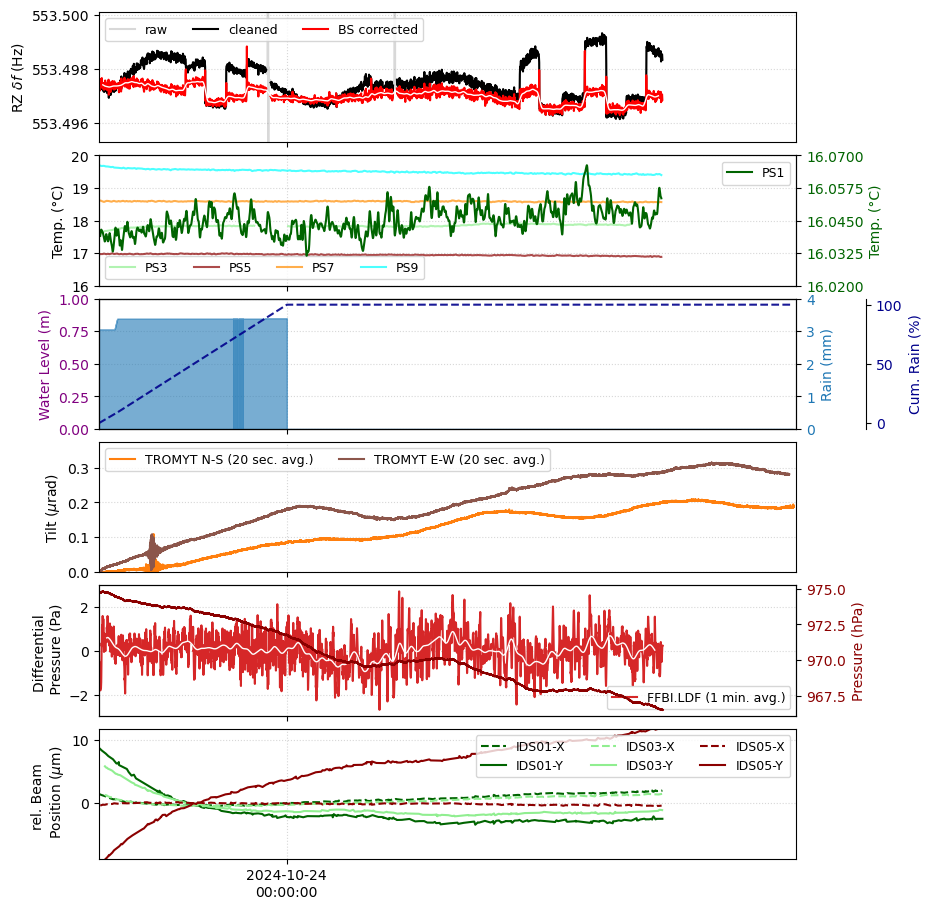

In [34]:
fig = __makeplot();

fig.savefig(config['path_to_figs']+f"html_environmentals.png", format="png", dpi=150, bbox_inches='tight')

del fig